In [1]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from src.unet.loss import MixedLoss
from src.unet.lit_unet import LitUNet
import torch
from src.rfc_dataset import RFCDataset
from torch.utils.data import ConcatDataset, DataLoader
from src.unet.loss import MixedLoss
import cv2

In [2]:
device = "cpu"  # "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cpu device


## Load the model


In [3]:
model = LitUNet.load_from_checkpoint(
    "../checkpoints-0605-0023-ce+bd+md+rw-0.5/epoch=94-step=214158-val_bin_dice=0.18.ckpt",
)
model.to(device)
model.eval();

Using class counts


/home/david/miniconda3/envs/ribfrac/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/david/miniconda3/envs/ribfrac/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


## Create the validation data loader


In [4]:
def get_val_loader(batch_size=1):
    val_pos = RFCDataset(
        data_dir="../data/ribfrac-challenge/validation/prepared/pos",
    )
    val_neg = RFCDataset(
        data_dir="../data/ribfrac-challenge/validation/prepared/neg",
    )
    val_data = ConcatDataset([val_pos, val_neg])
    # val_data = Subset(val_data, torch.randperm(len(val_data)))
    val_loader = DataLoader(
        val_data, batch_size=batch_size, persistent_workers=True, num_workers=1
    )
    return val_data, val_loader


In [5]:
dataset, data_loader = get_val_loader()
print("Num validation slices:", len(data_loader))


Num validation slices: 26420


## Take a look at a single slice


In [6]:
batch_0 = dataset[700]
img_0 = batch_0["image"]
label_0 = batch_0["label"]


In [7]:
print("img shape:", img_0.shape)


img shape: torch.Size([1, 512, 512])


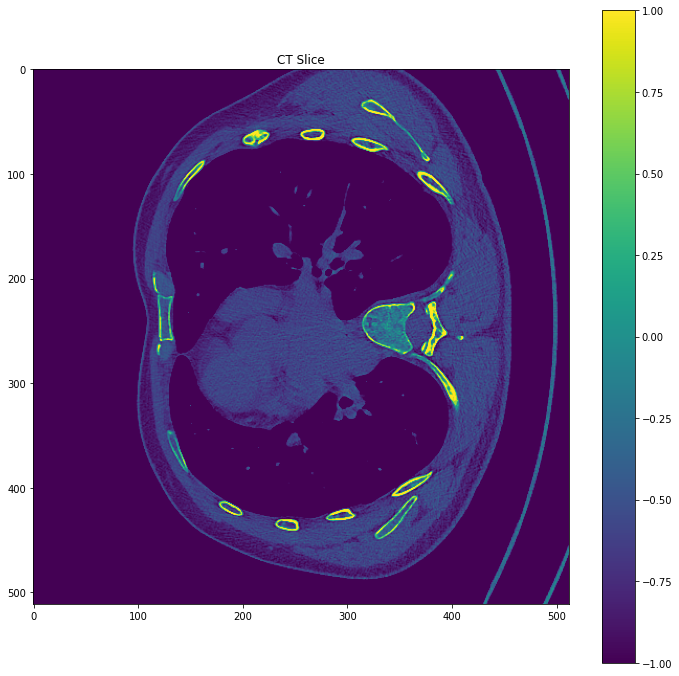

In [8]:
fig = plt.figure(figsize=(12, 12))
plt.title("CT Slice")
plt.imshow(img_0[0])
plt.colorbar()


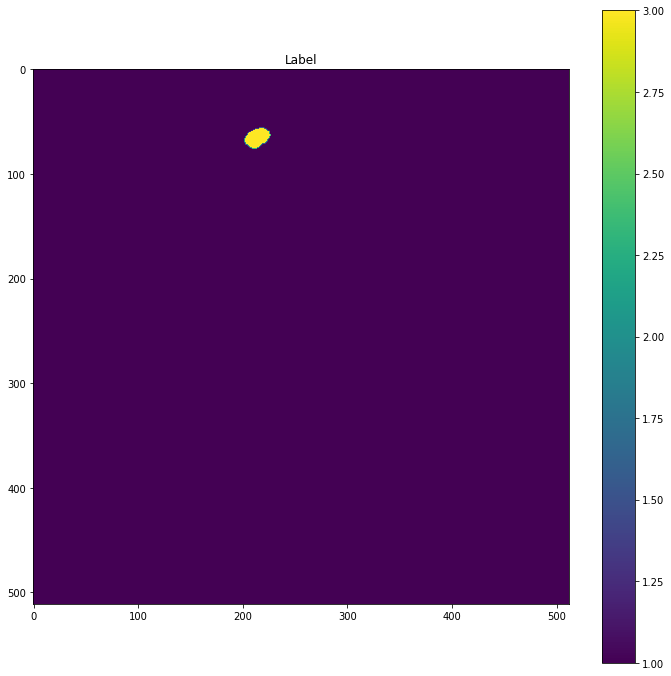

In [9]:
plt.figure(figsize=(12, 12))
plt.title("Label")
plt.imshow(label_0)
plt.colorbar()


In [10]:
print("max:", label_0.max().item())
print("min:", label_0.min().item())
print("unique label values:", label_0.unique().numpy())


max: 3
min: 1
unique label values: [1 3]


## Run model on the same slice


In [11]:
out = model(img_0.unsqueeze(0).to(device)).cpu()
probs = MixedLoss.get_softmax_scores(out)
binary_probs = (1 - probs[:, 1]).squeeze().detach().cpu().numpy()


## Set probability threshold


In [12]:
bin_prob_thresh = 0.9
binary_probs[binary_probs < bin_prob_thresh] = 0


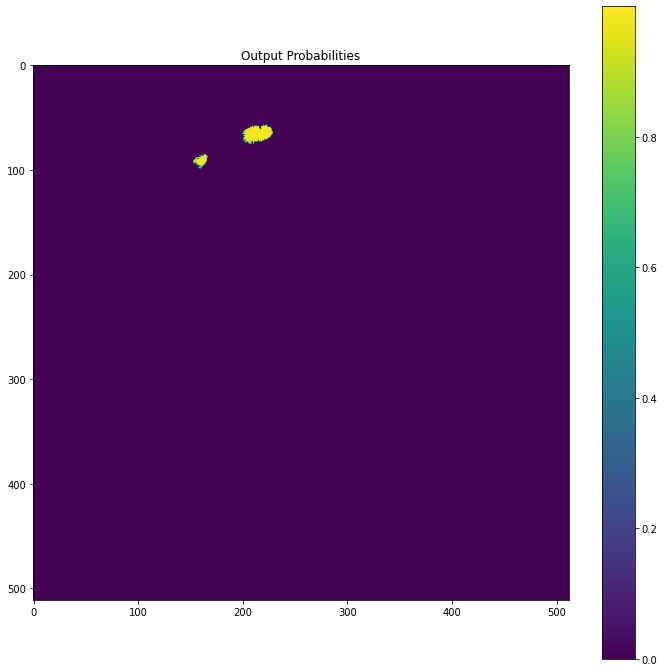

In [13]:
plt.figure(figsize=(12, 12))
plt.title("Output Probabilities")
plt.imshow(binary_probs)
plt.colorbar()


# Binary DICE


In [14]:
mixed_loss = MixedLoss(model.params)
label_0_one_hot = torch.nn.functional.one_hot(label_0.unsqueeze(0), num_classes=6)
label_0_one_hot = label_0_one_hot.type(torch.int8).permute(0, 3, 1, 2)
binary_dice = mixed_loss.get_binary_dice_score(
    probs, label_0.unsqueeze(0), label_0_one_hot
)
print(f"Binary DICE: {binary_dice.item():.2f}")


Binary DICE: 0.65


## OpenCV Blob Detection


In [15]:
def get_bin_prob_blobs(bin_probs, threshold=0.9):
    threshold = int(255 * threshold)
    x = (bin_probs * 255).astype(np.uint8)
    _, x = cv2.threshold(x, threshold, 255, cv2.THRESH_BINARY_INV)
    x = cv2.GaussianBlur(x, (3, 3), 0)
    params = cv2.SimpleBlobDetector_Params()
    params.minThreshold = threshold
    params.maxThreshold = 255
    params.filterByArea = True
    params.minArea = 5
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(x)
    return keypoints


def get_label_slice_blobs(label_slice):
    x = label_slice.copy()
    x = (x != 1).astype(np.uint8)
    x = cv2.normalize(
        x, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U
    )
    _, x = cv2.threshold(x, 100, 255, cv2.THRESH_BINARY_INV)
    x = cv2.GaussianBlur(x, (3, 3), 0)
    params = cv2.SimpleBlobDetector_Params()
    params.filterByArea = True
    params.minArea = 5
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(x)
    return keypoints


## Visualize Blobs


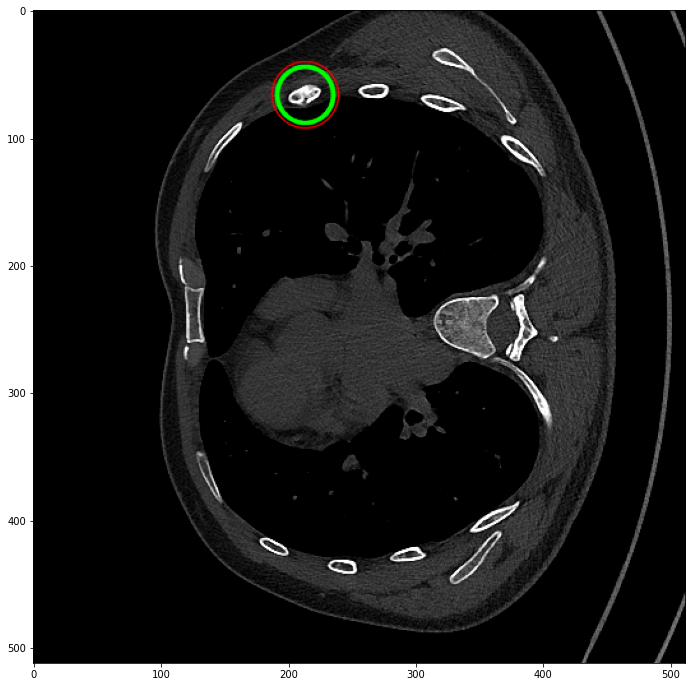

In [16]:
bin_prob_blobs = get_bin_prob_blobs(binary_probs)
label_blobs = get_label_slice_blobs(label_0.numpy())
gray_img_0 = cv2.normalize(
    img_0[0].numpy(),
    None,
    alpha=0,
    beta=255,
    norm_type=cv2.NORM_MINMAX,
    dtype=cv2.CV_8U,
)

vis_img = gray_img_0.copy()
vis_img = cv2.cvtColor(vis_img, cv2.COLOR_GRAY2RGB)
for blob in label_blobs:
    x = int(blob.pt[0])
    y = int(blob.pt[1])
    r = int(blob.size)
    cv2.circle(vis_img, (x, y), r, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

for blob in bin_prob_blobs:
    x = int(blob.pt[0])
    y = int(blob.pt[1])
    r = int(blob.size)
    cv2.circle(vis_img, (x, y), r, color=(255, 0, 0), thickness=1, lineType=cv2.LINE_AA)

plt.figure(figsize=(12, 12))
plt.imshow(vis_img)
